In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from ast import literal_eval
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import time

#### Restaurants Ranking share

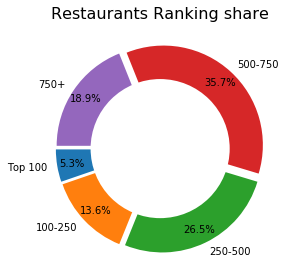

In [3]:
labels = ['Top 100', '100-250', '250-500', '500-750', '750+']
sizes = [82, 212, 412, 556, 295]
explode = (0.05,0.05,0.05,0.05,0.05)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Restaurants Ranking share', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/Ranking_share.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

SVM accuracy improved with median Zero and target values (-1, 1)

In [4]:
df_full = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted_with_mean_True.csv')
df = df_full.copy()

Targets generation:

In [4]:
print ('{} samples with ranking <= 250'.format(df.loc[df['Ranking'] <= 250, 'Ranking'].count()))
print ('{} samples with ranking <= 500'.format(df.loc[df['Ranking'] <= 500, 'Ranking'].count()))
print ('{} samples with ranking <= 1500'.format(df.loc[df['Ranking'] <= 1500, 'Ranking'].count()))

212 samples with ranking <= 250
412 samples with ranking <= 500
811 samples with ranking <= 1500


As we see, these numbers are around the double from the previous one. So for each class we'll work with a different number of samples in order to keep y-variance close to unit. Doing this, the classifier will work under an unbiased training.<br>
From the full dataset samples with ranking:
* <= 500 for Top_250 
* <= 1500 for Top_500

In [6]:
df.loc[(df['Ranking'] <= 250), 'Top_250'] = 1
df.loc[(df['Ranking'] > 250), 'Top_250'] = -1
df.loc[(df['Ranking'] <= 500), 'Top_500'] = 1
df.loc[(df['Ranking'] > 500), 'Top_500'] = -1

# <a id="code0">SVM (Support Vector Machine)</a>

### Cross Validation modifying random_parameter at splitting the dataset

SVM works very well on smaller data sets, on non-linear data sets and high dimensional spaces. Not very sensitive to overfitting.<br>
When the data set has more noise (i.e. target classes are overlapping) SVM doesn’t perform well. We need to find classes that do not overlap. This is why using Ranking we obtain better results than using Rating.

* We are running the SVM classifier for all combinations of features.
* random_state from 0 to 100 and multiple of 3. This will serve as Cross Validation. Otherwise, fixing the seed (random_state) which generates the test set, wouldn't get optimal results. 
* Data has been splitted in 80/20 ratio, 80% for train set and 20% for test set.
* Regularization Parameter C has been fixed to 5 due to previous tests with this model. There's no increment on accuracy with values above 10. 
* Gamma parameter gave us better results slightly modifying the default (from version SVM 0.22) 'scale', which is 1/(n_features * X.var()). We are using (1.15 / (X.shape[1] * X.var()))
* Kernels ('linear', 'poly', 'rbf', 'sigmoid') also has been tested. Radial Basis Function was the most accurate followed by Polynomial. This is due to our model is non-linear.
* F1-measure, which weights precision and recall equally, is the variant most often used when learning from imbalanced data. We cannot base our study just on accuracy for this model in particular.

SVM first approach with the entire Feature set 

In [7]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit

X = np.asarray(dff[['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum','Restaurant', 'Company', 
                    'Liffey', 'Price Area']])
y = np.asarray(dff['Top_250']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84, stratify=dff['Top_250']) #Top_250/Top_500
clf = svm.SVC(kernel='rbf', C=5, probability=True, gamma=(1.15 / (X.shape[1] * X.var())))  #probability=True for ROC Curve
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.6144578313253012
f1: 0.611399770645449
jaccard: 0.4416326291165881


#### Let's check with different combinations of feature set

Instead of trying a feature set that has been chosen during Feature selection, we will calculate all possible combinations of feature sets. With each one, we run the classifier and get the accuracy. Albeit we had estimated the best features with different tools during the Feature Selection process, with a dataset of about 1000 samples this is an interesting approach due to these calculations won't be high intensive computing. 

In [13]:
features = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum','Restaurant', 'Company', 'Liffey', 'Price Area']
feat_combo = []
for L in range(1, len(features)+1):
    for subset in itertools.combinations(features, L):
        feat_combo.append(subset)
print ('There are {} different combinations of feature set'.format(len(feat_combo)))

There are 2047 different combinations of feature set


Dataframe where we save the classifier's results

In [9]:
svm_total_top_250 = pd.DataFrame(columns=['combo', 'accuracy', 'accuracy_train', 
                                          'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])
svm_total_top_500 = pd.DataFrame(columns=['combo', 'accuracy', 'accuracy_train', 
                                          'f1_score', 'jaccard_score', 'random_state', 'nFeatures'])

In [10]:
start = time.time()
# limiting the samples scope in order to have y-variance close to unit (defining 1,-1 binomial target) for a balanced model
dff = df.loc[df['Ranking'] <= 500].copy() #500/1500
space = '     ' # to print on same line while calculating
svm_combo = pd.DataFrame(columns=['combo', 'accuracy', 'accuracy_train', 'f1_score', 'jaccard_score', 
                                  'random_state', 'nFeatures'])
j=0
i=0
for j in range(0, 100, 3):
    for i in range (0, len(feat_combo)):
        X = np.asarray(dff[list(feat_combo[i])])  
        y = np.asarray(dff['Top_250'])#Top_250/Top_500
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=j, stratify=dff['Top_250'])#Top_250/Top_500
        clf = svm.SVC(kernel='rbf', C=5, gamma=(1.15 / (X.shape[1] * X.var())))
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        
        svm_combo.at[i, 'combo'] = list(feat_combo[i])
        svm_combo.at[i, 'accuracy'] = metrics.accuracy_score(y_test, yhat)
        svm_combo.at[i, 'accuracy_train'] = metrics.accuracy_score(y_train, y_pred_train)
        svm_combo.at[i, 'f1_score'] = f1_score(y_test, yhat, average='weighted')
        svm_combo.at[i, 'jaccard_score'] = jaccard_score(y_test, yhat, average='weighted')
        svm_combo.at[i, 'random_state'] = j
        svm_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))

        print( 'random_state:{},{}{}'.format(j, svm_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
    svm_total_top_250 = svm_total_top_250.append(svm_combo)#Top_250/Top_500
print(round(time.time() - start, 3))

18.645_state:0,['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Company', 'Liffey', 'Price Area']                                                  


In [14]:
svm_total_top_250.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,accuracy_train,f1_score,jaccard_score,random_state,nFeatures
57759,"['University', 'Cafe', 'Luas', 'Company']",0.734940,0.620061,0.734246,0.580177,84,4
57464,"['University', 'Cafe', 'Luas']",0.710843,0.623100,0.710087,0.550594,84,3


In [15]:
svm_total_top_500.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,accuracy_train,f1_score,jaccard_score,random_state,nFeatures
27839,"['Hotel', 'Cafe', 'Pub', 'Luas', 'Liffey', 'Pr...",0.693252,0.628086,0.691741,0.529290,39,6
28265,"['Hotel', 'University', 'Pub', 'Luas', 'Restau...",0.693252,0.634259,0.690474,0.528201,39,7


In [13]:
#svm_total_top_250 = pd.read_csv('CSVs/svm_total_top_250.csv')
#svm_total_top_500 = pd.read_csv('CSVs/svm_total_top_500.csv')

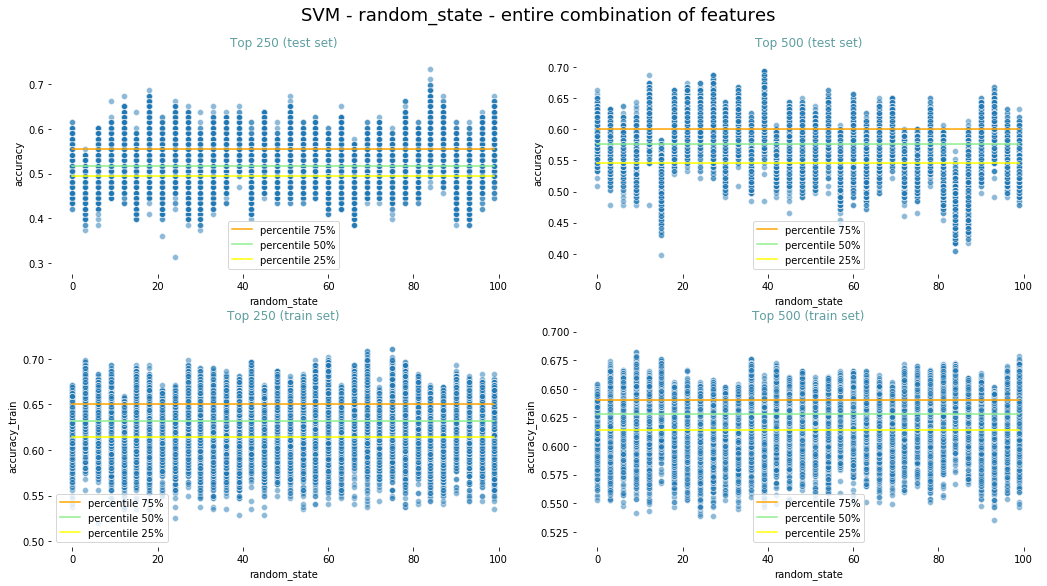

In [16]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1)]
axis_x = 'random_state'
axis_y = ['accuracy', 'accuracy', 'accuracy_train', 'accuracy_train']
titles_figs =['Top 250 (test set)', 'Top 500 (test set)', 'Top 250 (train set)', 'Top 500 (train set)']

data_dfs = [svm_total_top_250, svm_total_top_500, svm_total_top_250, svm_total_top_500]
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('SVM - random_state - entire combination of features', y=1.02, fontsize=18)

for data_df, ax_y, titl, figs in zip(data_dfs, axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=0.5)
    sns.lineplot(x=axis_x, y=data_df[ax_y].quantile(q=0.75), data=data_df, color='orange', label='percentile 75%',
                 ax=axs[figs], alpha=1).set_title(titl, color='cadetblue')
    sns.lineplot(x=axis_x, y=data_df[ax_y].quantile(q=0.50), data=data_df, color='lightgreen', label='percentile 50%',
             ax=axs[figs], alpha=1)
    sns.lineplot(x=axis_x, y=data_df[ax_y].quantile(q=0.25), data=data_df, color='yellow', label='percentile 25%',
             ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_entire_combo_random_state.png', bbox_inches='tight', format='png', dpi=500)

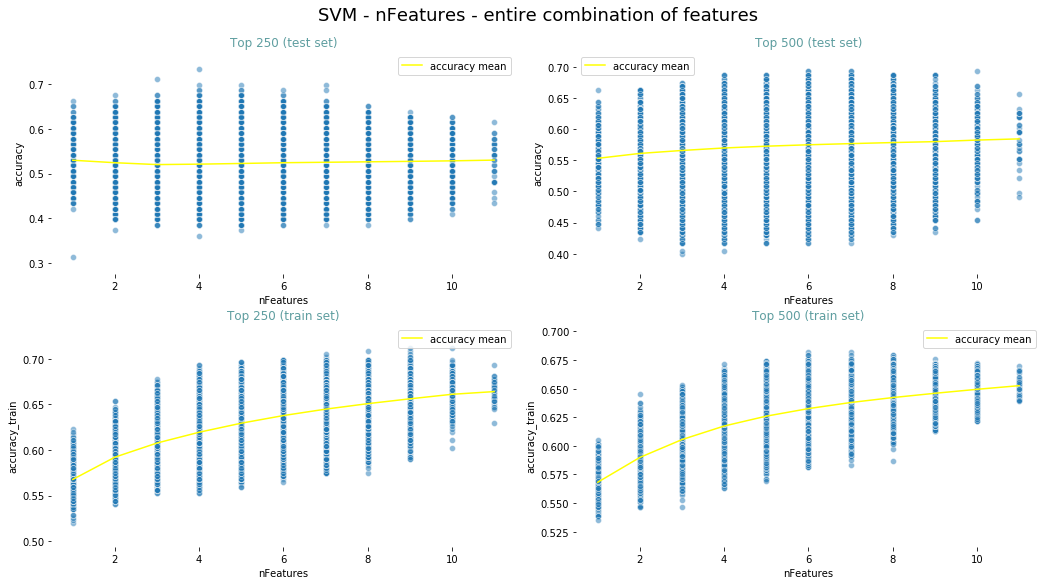

In [17]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1)]
axis_x = 'nFeatures'
axis_y = ['accuracy', 'accuracy', 'accuracy_train', 'accuracy_train']
titles_figs =['Top 250 (test set)', 'Top 500 (test set)', 'Top 250 (train set)', 'Top 500 (train set)']

data_dfs = [svm_total_top_250, svm_total_top_500, svm_total_top_250, svm_total_top_500]
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('SVM - nFeatures - entire combination of features', y=1.02, fontsize=18)

for data_df, ax_y, titl, figs in zip(data_dfs, axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=0.5).set_title(titl, color='cadetblue')
    sns.lineplot(x=data_df.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data_df.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data_df, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_entire_combo_nfeatures.png', bbox_inches='tight', format='png', dpi=500)

In [18]:
svm_total_top_250.groupby(by=['nFeatures']).mean()['accuracy'].values

array([0.52983055, 0.52428967, 0.5200975 , 0.52107682, 0.52258998,
       0.52430808, 0.52527758, 0.52630629, 0.52731138, 0.52847755,
       0.53012048])

Let's keep those combos that pass the threshold of percentile 75% accuracy, and count the times each feature appears

In [19]:
feature_set = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 
               'Luas', 'Museum','Restaurant', 'Company', 'Liffey', 'Price Area']
df_app = pd.DataFrame(columns=['Feature'])
df_app.at[0, 'Feature'] = 'Top_250'
df_app.at[1, 'Feature'] = 'Top_500'
data_dfs = [svm_total_top_250, svm_total_top_500]
for ind, data in zip(range(0,2), data_dfs):
    df_temp = pd.DataFrame()
    df_temp = data.loc[data['accuracy'] >= data.accuracy.quantile(q=0.75)].copy()
    df_temp.reset_index(drop=True, inplace=True)
    for feat in feature_set:
        df_app.at[ind, feat] = df_temp.loc[df_temp['combo'].str.contains(feat), 'combo'].count()
df_fc = df_app.set_index('Feature').transpose()   
df_fc.reset_index(inplace=True)
df_fc.rename(columns={'index':'Feature'}, inplace=True)
df_fc.rename_axis(None, inplace=True)
df_fc.sort_values(by=['Top_250'], inplace=True)

Feature repetitions comparison above 75% percentile accuracy

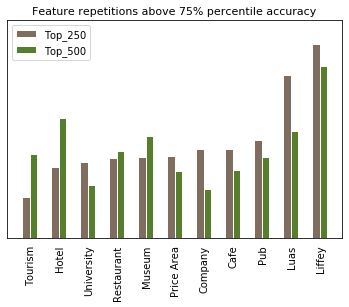

In [20]:
barWidth = 0.25
bars1 = list(df_fc.iloc[:,1].round(0))
bars2 = list(df_fc.iloc[:,2].round(0))
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
fig, ax = plt.subplots()
ax.set(ylim=[8000, 14000]) 

plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Top_250')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Top_500')

ax.tick_params(labelleft=False, left=False, bottom=False)  
plt.xticks([r-0.09 + barWidth for r in range(len(bars1))], list(df_fc.Feature), rotation=90)
plt.title('Feature repetitions above 75% percentile accuracy', fontsize=11)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.legend()
plt.savefig('charts/SVM_Feature_rep_above75pct_acc.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

Technically we should have a look just at the combinations itself, not at individual features. However, this chart shows us that there are 2 predominant features for the Top_250 model ('Luas' & 'Liffey') and similarly 4 for Top_500 model ('Luas', Liffey', 'Hotel' & 'Museum').

In [21]:
svm_total_top_250.sort_values(by=['accuracy'], ascending=False).head(10)

,combo,accuracy,accuracy_train,f1_score,jaccard_score,random_state,nFeatures
57759,"['University', 'Cafe', 'Luas', 'Company']",0.734940,0.620061,0.734246,0.580177,84,4
57464,"['University', 'Cafe', 'Luas']",0.710843,0.623100,0.710087,0.550594,84,3
58232,"['University', 'Cafe', 'Luas', 'Restaurant', '...",0.698795,0.613982,0.696422,0.534671,84,5
57758,"['University', 'Cafe', 'Luas', 'Restaurant']",0.698795,0.604863,0.698795,0.537037,84,4
59095,"['University', 'Cafe', 'Pub', 'Luas', 'Museum'...",0.698795,0.620061,0.697568,0.535780,84,7
59124,"['Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant'...",0.686747,0.638298,0.686838,0.523054,84,7
58307,"['Cafe', 'Luas', 'Museum', 'Company', 'Price A...",0.686747,0.650456,0.686838,0.523054,84,5
58252,"['University', 'Pub', 'Luas', 'Restaurant', 'C...",0.686747,0.604863,0.684922,0.521137,84,5
58789,"['Cafe', 'Luas', 'Museum', 'Restaurant', 'Comp...",0.686747,0.632219,0.686565,0.522737,84,6
57826,"['Cafe', 'Luas', 'Restaurant', 'Company']",0.686747,0.610942,0.685927,0.522099,84,4


In [22]:
svm250 = svm_total_top_250.copy()
svm250_Top = svm250.loc[(svm250['combo'].str.contains('Luas')) 
                       & (svm250['combo'].str.contains('Liffey')) 
                       & (svm250['combo'].str.contains('Cafe|Pub'))]

In [23]:
svm250_Top.sort_values(by=['accuracy'], ascending=False).head(10)

,combo,accuracy,accuracy_train,f1_score,jaccard_score,random_state,nFeatures
59127,"['Cafe', 'Pub', 'Luas', 'Restaurant', 'Company...",0.662651,0.647416,0.658264,0.492317,84,7
58791,"['Cafe', 'Luas', 'Museum', 'Company', 'Liffey'...",0.662651,0.650456,0.661270,0.494636,84,6
58989,"['Hotel', 'Cafe', 'Pub', 'Luas', 'Restaurant',...",0.662651,0.644377,0.658264,0.492317,84,7
58564,"['Hotel', 'Cafe', 'Luas', 'Company', 'Liffey',...",0.662651,0.650456,0.658264,0.492317,84,6
60332,"['Cafe', 'Pub', 'Luas', 'Museum', 'Liffey']",0.650602,0.650456,0.650602,0.482143,87,5
58039,"['Hotel', 'Cafe', 'Luas', 'Company', 'Liffey']",0.650602,0.644377,0.647000,0.479666,84,5
36047,"['Hotel', 'Cafe', 'Luas', 'Company', 'Liffey',...",0.650602,0.656535,0.642563,0.476300,51,6
59002,"['Hotel', 'Cafe', 'Luas', 'Restaurant', 'Compa...",0.650602,0.650456,0.647000,0.479666,84,7
17350,"['Cafe', 'Pub', 'Luas', 'Company', 'Liffey']",0.650602,0.647416,0.647000,0.479666,24,5
58146,"['Tourism', 'Cafe', 'Pub', 'Luas', 'Liffey']",0.650602,0.647416,0.650399,0.482151,84,5


Out of the top 10 accuracy, 7 belong to the same random_state 84 (seed generator for splitting the dataset into train & test sets). This tell us that was a peak and not completely representative of the classifier's accuracy.

### <a id="code1">SVM Cross Validation using K-Fold and cross_val_score</a>

### Top_250

In [241]:
df_full = pd.read_csv('CSVs/Restaurants_Full_Grouped_sorted_with_mean_True.csv')
df = df_full.copy()
df.loc[(df['Ranking'] <= 250), 'Top_250'] = 1
df.loc[(df['Ranking'] > 250), 'Top_250'] = -1
df.loc[(df['Ranking'] <= 500), 'Top_500'] = 1
df.loc[(df['Ranking'] > 500), 'Top_500'] = -1

Creating the feature combinations list

In [259]:
features = ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum','Restaurant', 'Company', 'Liffey', 'Price Area']
feat_combo = []
for L in range(1, len(features)+1):
    for subset in itertools.combinations(features, L):
        feat_combo.append(subset)
print ('There are {} different combinations of feature set'.format(len(feat_combo)))

There are 2047 different combinations of feature set


In [267]:
svm_KF_CV_250 = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures'])

In [268]:
start = time.time()
# limiting the samples scope in order to have y-variance close to unit (defining 1,-1 binomial target) for a balanced model
dff = df.loc[df['Ranking'] <= 500].copy()
space = '     ' # to print on same line while calculating
# iterated dataframe
svm_combo = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures'])
i=0
for i in range (0, len(feat_combo)):
    # adding features and target
    X = np.asarray(dff[list(feat_combo[i])])  
    y = np.asarray(dff['Top_250'])
    # setting the classifier
    clf = svm.SVC(kernel = 'rbf', C=5, gamma=(1.15 / (X.shape[1] * X.var())))
    # KFold
    scores = []
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    # cross_val_score
    cv_scores = cross_val_score(clf, X, y, cv=10)
    
    # adding to iterated dataframe
    svm_combo.at[i, 'combo'] = 'fixing bug passing a list into a cell not being an object'
    svm_combo.at[i, 'combo'] = list(feat_combo[i])
    svm_combo.at[i, 'KF_acc_mean'] = np.mean(scores)
    svm_combo.at[i, 'KF_acc_max'] = np.max(scores)
    svm_combo.at[i, 'KF_acc_min'] = np.min(scores)
    svm_combo.at[i, 'KF_var'] = np.var(scores)
    svm_combo.at[i, 'CV_acc_mean'] = cv_scores.mean()
    svm_combo.at[i, 'CV_acc_max'] = cv_scores.max()
    svm_combo.at[i, 'CV_acc_min'] = cv_scores.min()
    svm_combo.at[i, 'CV_var'] = cv_scores.var()
    svm_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))

    print( '{}{}'.format(svm_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
# adding each row from the iterated dataframe to the final dataframe
svm_KF_CV_250 = svm_KF_CV_250.append(svm_combo)
print(round(time.time() - start, 3))

167.505', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Company', 'Liffey', 'Price Area']                                                  


In [660]:
#svm_KF_CV_250.to_csv('CSVs/svm_KF_CV_250.csv', index=False)

In [269]:
svm_KF_CV_250.sort_values(by=['KF_acc_max'], ascending=False).head()

,combo,KF_acc_mean,KF_acc_max,KF_acc_min,KF_var,CV_acc_mean,CV_acc_max,CV_acc_min,CV_var,nFeatures
549,"[Luas, Museum, Company, Liffey]",0.405168,0.658537,0.268293,0.0125537,0.514576,0.595238,0.428571,0.00251352,4
759,"[Hotel, Luas, Museum, Company, Liffey]",0.395354,0.658537,0.268293,0.0138426,0.521893,0.609756,0.428571,0.00355541,5
1618,"[Hotel, University, Cafe, Pub, Luas, Company, ...",0.388444,0.634146,0.243902,0.0119532,0.519396,0.609756,0.463415,0.00197534,7
1785,"[University, Cafe, Pub, Luas, Restaurant, Comp...",0.383391,0.634146,0.219512,0.0142668,0.529036,0.619048,0.439024,0.00384321,7
1226,"[Hotel, Cafe, Pub, Luas, Company, Liffey]",0.37619,0.634146,0.268293,0.0105816,0.519338,0.609756,0.487805,0.00168295,6


Converting columns object to float to work with

In [346]:
for column in list(svm_KF_CV_250.columns)[1:]:
    svm_KF_CV_250[column] = svm_KF_CV_250[column].astype('float')

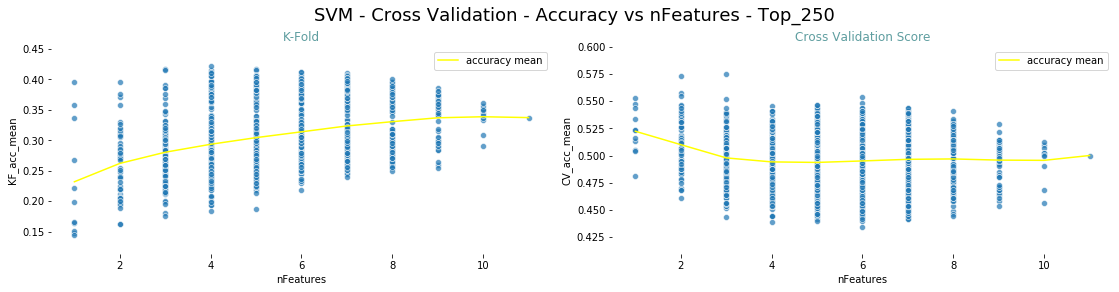

In [414]:
figures = [0, 1]
axis_x = 'nFeatures'
axis_y = ['KF_acc_mean', 'CV_acc_mean']
titles_figs =['K-Fold', 'Cross Validation Score']
data = svm_KF_CV_250
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
fig.tight_layout(pad=3.0)
fig.suptitle('SVM - Cross Validation - Accuracy vs nFeatures - Top_250', y=1.02, fontsize=18)

for ax_y, titl, figs in zip(axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.7).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_Cross_Val_combo_nfeatures.png', bbox_inches='tight', format='png', dpi=500)

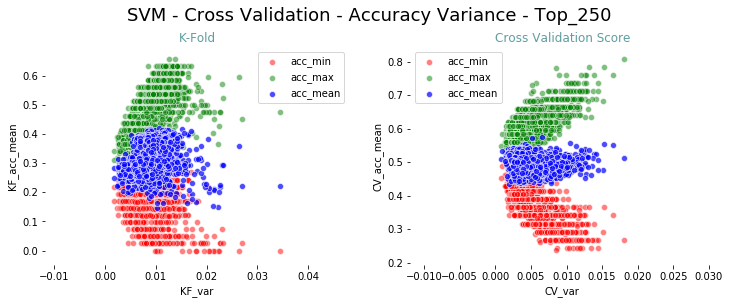

In [416]:
figures = [0, 1]
axis_x = ['KF_var', 'CV_var']
axis_y_min = ['KF_acc_min', 'CV_acc_min']
axis_y_mean = ['KF_acc_mean', 'CV_acc_mean']
axis_y_max = ['KF_acc_max', 'CV_acc_max']
titles_figs =['K-Fold', 'Cross Validation Score']
data = svm_KF_CV_250
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
fig.suptitle('SVM - Cross Validation - Accuracy Variance - Top_250', y=1.02, fontsize=18)
for ax_yi, ax_yea, ax_ya, ax_x, titl, figs in zip(axis_y_min, axis_y_mean, 
                                                  axis_y_max, axis_x, titles_figs, figures):
    sns.scatterplot(x=ax_x, y=ax_yi, data=svm_KF_CV_250, alpha=0.5, 
                    label='acc_min', color='red', ax=axs[figs]).set_title(titl, color='cadetblue')
    sns.scatterplot(x=ax_x, y=ax_ya, data=svm_KF_CV_250, alpha=0.5, 
                    label='acc_max', color='green', ax=axs[figs])
    sns.scatterplot(x=ax_x, y=ax_yea, data=svm_KF_CV_250, alpha=0.7, 
                    label='acc_mean', color='blue', ax=axs[figs])
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_Cross_Val_Accuracy_Variance.png', bbox_inches='tight', format='png', dpi=500)

In order to find the best combination of features for the model we must get the group with the highest accuracy and lowest variance for K-Fold and Cross Validation and see if we get a match.<br>
For example, high accuracy & low variance on the density chart would be the points on the left side of the green points. Each point on each color group represents one combination of features. In this case we might start looking for points with > 0.5 acc & < 0.01 variance on the KFold and see if we get a match on the Cross Validation side.

For each single combination of features, point in the chart in a color group, there are mirrors in the other 2 groups, due to these points sharing the same variance. A clear example is shown by the outliers on the right side (3 dots within the lightblue box). These 3 points represent a unique combination of features. Following this thought, on the Cross Validation chart we notice a feature set with the highest accuracy, however it also has one of the worst. Therefore we are interested in the dots on the left hand side of each chart.

<tr>
<td> <img src="charts/K-Fold_Point.PNG" alt="K-Fold" style="height:300px;"/> </td>
<td> <img src="charts/CrossV_Point.PNG" alt="CV" style="height:300px;"/> </td>
</tr>

In [351]:
svm_KF_CV_250.sort_values(by=['CV_acc_max'], ascending=False).head()

,combo,KF_acc_mean,KF_acc_max,KF_acc_min,KF_var,CV_acc_mean,CV_acc_max,CV_acc_min,CV_var,nFeatures
128,"[Tourism, Pub, Restaurant]",0.290592,0.500000,0.024390,0.014941,0.513821,0.809524,0.268293,0.018012,3.0
46,"[Pub, Museum]",0.318118,0.463415,0.024390,0.018765,0.554936,0.785714,0.365854,0.015198,2.0
496,"[Cafe, Pub, Museum, Restaurant]",0.276249,0.523810,0.024390,0.014193,0.537979,0.785714,0.365854,0.013164,4.0
474,"[University, Luas, Museum, Price Area]",0.283391,0.439024,0.073171,0.011522,0.541405,0.780488,0.439024,0.008455,4.0
178,"[Cafe, Pub, Company]",0.293844,0.439024,0.243902,0.003579,0.518815,0.761905,0.317073,0.012749,3.0


In [447]:
print('KFold: {}'.format(svm_KF_CV_250.loc[(svm_KF_CV_250['KF_var'] < 0.01) 
                        & (svm_KF_CV_250['KF_acc_max'] > 0.5), 'nFeatures'].count()))
print('CV: {}'.format(svm_KF_CV_250.loc[(svm_KF_CV_250['CV_var'] < 0.005) 
                        & (svm_KF_CV_250['CV_acc_max'] > 0.6), 'nFeatures'].count()))

KFold: 344
CV: 425


Let's define some conditions:
* K-Fold < 0.01 variance & > 0.5 accuracy 
* CV < 0.005 variance & > 0.6 accuracy
* combo always above mean() for same nFeature 


In [491]:
KFold_1 = svm_KF_CV_250.loc[(svm_KF_CV_250['KF_var'] < 0.01) 
                            & (svm_KF_CV_250['KF_acc_max'] > 0.5)].copy()
CV_1 = svm_KF_CV_250.loc[(svm_KF_CV_250['CV_var'] < 0.005) 
                            & (svm_KF_CV_250['CV_acc_max'] > 0.6)].copy()
KFold_1.reset_index(drop=True, inplace=True)
CV_1.reset_index(drop=True, inplace=True)

We first save the accuracy values of the grouped by nFeatures. These values represent the yellow accuracy mean on the previous chart

In [497]:
KFold_n_max = svm_KF_CV_250.groupby(by=['nFeatures']).mean()['KF_acc_max'].values
KFold_n_mean = svm_KF_CV_250.groupby(by=['nFeatures']).mean()['KF_acc_mean'].values
KFold_n_min = svm_KF_CV_250.groupby(by=['nFeatures']).mean()['KF_acc_min'].values

CV_n_max = svm_KF_CV_250.groupby(by=['nFeatures']).mean()['CV_acc_max'].values
CV_n_mean = svm_KF_CV_250.groupby(by=['nFeatures']).mean()['CV_acc_mean'].values
CV_n_min = svm_KF_CV_250.groupby(by=['nFeatures']).mean()['CV_acc_min'].values

Now we create new dataframes applying the third condition:
* combo always above mean() for same nFeature 

In [498]:
KFold_2 = pd.DataFrame()
CV_2 = pd.DataFrame()
i=0
for i in range (0, len(KFold_1)):
    if (KFold_1.at[i, 'KF_acc_mean'] > KFold_n_mean[int(KFold_1.at[i, 'nFeatures'])-1]):
        if (KFold_1.at[i, 'KF_acc_min'] > KFold_n_min[int(KFold_1.at[i, 'nFeatures'])-1]):
            if (KFold_1.at[i, 'KF_acc_max'] > KFold_n_max[int(KFold_1.at[i, 'nFeatures'])-1]):
                KFold_2 = KFold_2.append(KFold_1.iloc[i,:])
i=0
for i in range (0, len(CV_1)):
    if (CV_1.at[i, 'CV_acc_mean'] > CV_n_mean[int(CV_1.at[i, 'nFeatures'])-1]):
        if (CV_1.at[i, 'CV_acc_min'] > CV_n_min[int(CV_1.at[i, 'nFeatures'])-1]):
            if (CV_1.at[i, 'CV_acc_max'] > CV_n_max[int(CV_1.at[i, 'nFeatures'])-1]):
                CV_2 = CV_2.append(CV_1.iloc[i,:])

In [499]:
print('KFold group has been reduced from {} to {} samples'.format(KFold_1.shape[0], KFold_2.shape[0]))
print('CV group has been reduced from {} to {} samples'.format(CV_1.shape[0], CV_2.shape[0]))

KFold group has been reduced from 344 to 216 samples
CV group has been reduced from 425 to 265 samples


We compare KFold & CV groups to get matches

In [528]:
match_list = []
for KF in KFold_2.combo:
    for CV in CV_2.combo:
        if KF==CV:
            match_list.append(KF)
print('We got {} matches'.format(len(match_list)))

We got 65 matches


And create a dataframe in order to visualize the matches

In [519]:
KFold_2.reset_index(drop=True, inplace=True)
svm_match = pd.DataFrame()
for combo in match_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            svm_match = svm_match.append(KFold_2.iloc[i,:])

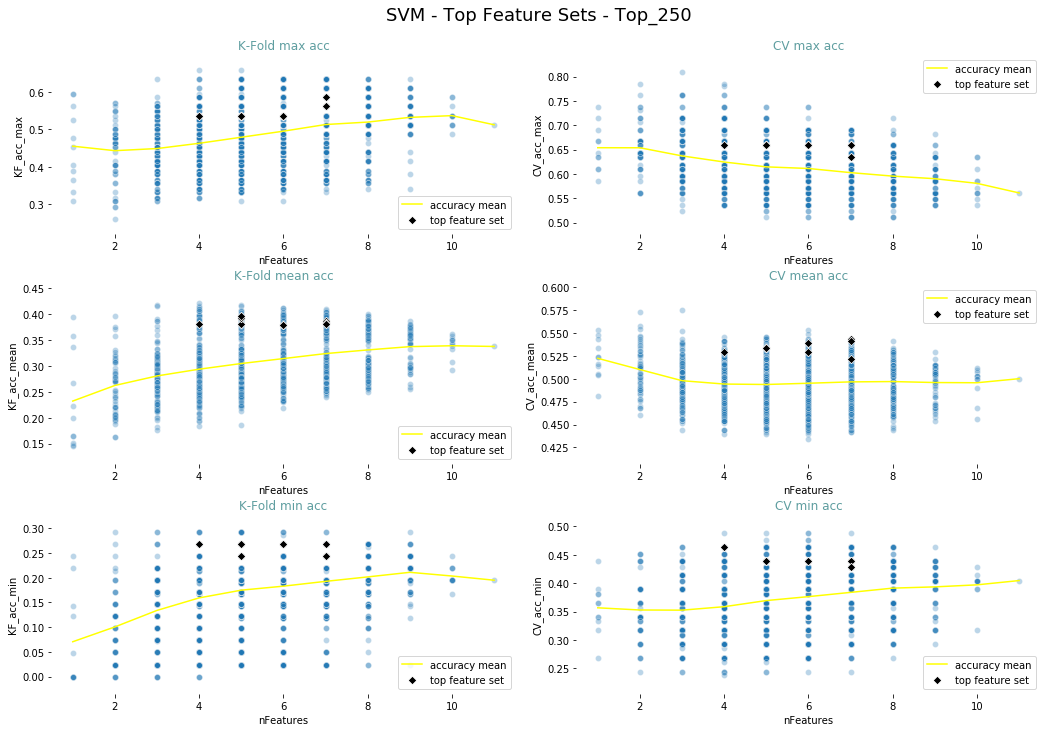

In [613]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
axis_x = 'nFeatures'
axis_y = ['KF_acc_max', 'CV_acc_max', 'KF_acc_mean', 'CV_acc_mean', 'KF_acc_min', 'CV_acc_min']
titles_figs =['K-Fold max acc', 'CV max acc', 'K-Fold mean acc', 'CV mean acc', 'K-Fold min acc', 'CV min acc']
data_dfs = [KFold_2, CV_2, KFold_2, CV_2, KFold_2, CV_2]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
#fig.suptitle('SVM - Best Feature Sets - Top_250', y=1.02, fontsize=18)
fig.suptitle('SVM - Top Feature Sets - Top_250', y=1.02, fontsize=18)

for ax_y, titl, data_df, figs in zip(axis_y, titles_figs, data_dfs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.3).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=1, label='potential match', color='red')
    #sns.scatterplot(x=axis_x, y=ax_y, data=svm_match, ax=axs[figs], alpha=1, label='match', color='darkgreen')
    sns.scatterplot(x=axis_x, y=ax_y, data=svm_top_feats, ax=axs[figs], alpha=1, label='top feature set', color='black', marker='D')
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_Top_Feature_Sets_Top_250.png', bbox_inches='tight', format='png', dpi=500)

This is great, but let's see how we can get the Top 10 Feature Sets
* we can increase the accuracy mean (yellow line) until we get 10 items in the match_list 

In [597]:
svm_top10_temp = match_list.copy()
KFold_2.reset_index(drop=True, inplace=True)
CV_2.reset_index(drop=True, inplace=True)
deltas = np.arange(1.01, 1.10, 0.01)

for delta in deltas: # we increase the accuracy mean 1% each iteration
    if len(svm_top10_temp) > 10:
        svm_top10_temp = []
        KFold_3 = pd.DataFrame()
        CV_3 = pd.DataFrame()
        i=0
        for i in range (0, len(KFold_2)):
            if (KFold_2.at[i, 'KF_acc_mean'] > (delta * (KFold_n_mean[int(KFold_2.at[i, 'nFeatures'])-1]))):
                if (KFold_2.at[i, 'KF_acc_min'] > (delta * (KFold_n_min[int(KFold_2.at[i, 'nFeatures'])-1]))):
                    if (KFold_2.at[i, 'KF_acc_max'] > (delta * (KFold_n_max[int(KFold_2.at[i, 'nFeatures'])-1]))):
                        KFold_3 = KFold_3.append(KFold_2.iloc[i,:])
        i=0
        for i in range (0, len(CV_2)):
            if (CV_2.at[i, 'CV_acc_mean'] > (delta * (CV_n_mean[int(CV_2.at[i, 'nFeatures'])-1]))):
                if (CV_2.at[i, 'CV_acc_min'] > (delta * (CV_n_min[int(CV_2.at[i, 'nFeatures'])-1]))):
                    if (CV_2.at[i, 'CV_acc_max'] > (delta * (CV_n_max[int(CV_2.at[i, 'nFeatures'])-1]))):
                        CV_3 = CV_3.append(CV_2.iloc[i,:])
        try:
            for KF in KFold_3['combo']:
                for CV in CV_3['combo']:
                    if KF==CV:
                        svm_top10_temp.append(KF)
            svm_top10_list = svm_top10_temp.copy()
        except:
            print('There are {} best combos with delta {}'.format(len(svm_top10_list), delta-0.01))
            break
    else:
        print('There are {} best combos with delta {}'.format(len(svm_top10_list), delta-0.01))
        break

There are 9 best combos with delta 1.05


In [598]:
svm_top10_list

[['Hotel', 'Pub', 'Luas', 'Liffey'],
 ['Hotel', 'University', 'Luas', 'Restaurant', 'Liffey'],
 ['Tourism', 'Pub', 'Luas', 'Liffey', 'Price Area'],
 ['University', 'Pub', 'Luas', 'Restaurant', 'Liffey'],
 ['Hotel', 'University', 'Pub', 'Luas', 'Restaurant', 'Liffey'],
 ['Tourism', 'Pub', 'Luas', 'Restaurant', 'Liffey', 'Price Area'],
 ['Hotel', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Liffey'],
 ['Hotel', 'University', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Liffey'],
 ['Hotel', 'University', 'Pub', 'Luas', 'Museum', 'Company', 'Liffey']]

In [599]:
svm_top_feats = pd.DataFrame()
for combo in svm_top10_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            svm_top_feats = svm_top_feats.append(KFold_2.iloc[i,:])

In [614]:
svm_top_feats

,CV_acc_max,CV_acc_mean,CV_acc_min,CV_var,KF_acc_max,KF_acc_mean,KF_acc_min,KF_var,combo,nFeatures
25,0.658537,0.529152,0.463415,0.004023,0.536585,0.380778,0.268293,0.008047,"[Hotel, Pub, Luas, Liffey]",4.0
65,0.658537,0.533972,0.439024,0.003769,0.536585,0.380952,0.268293,0.007386,"[Hotel, University, Luas, Restaurant, Liffey]",5.0
85,0.658537,0.534030,0.439024,0.003833,0.536585,0.393031,0.268293,0.009040,"[Tourism, Pub, Luas, Liffey, Price Area]",5.0
92,0.658537,0.533972,0.439024,0.004007,0.536585,0.395470,0.243902,0.008173,"[University, Pub, Luas, Restaurant, Liffey]",5.0
124,0.658537,0.538792,0.439024,0.004303,0.536585,0.378571,0.268293,0.007556,"[Hotel, University, Pub, Luas, Restaurant, Lif...",6.0
147,0.658537,0.529210,0.439024,0.004795,0.536585,0.378397,0.268293,0.009621,"[Tourism, Pub, Luas, Restaurant, Liffey, Price...",6.0
164,0.634146,0.543612,0.439024,0.003940,0.560976,0.385714,0.243902,0.009375,"[Hotel, Tourism, University, Cafe, Pub, Luas, ...",7.0
176,0.658537,0.541289,0.439024,0.003219,0.560976,0.383333,0.243902,0.009936,"[Hotel, University, Pub, Luas, Museum, Restaur...",7.0
177,0.658537,0.521951,0.428571,0.003989,0.585366,0.381243,0.268293,0.009740,"[Hotel, University, Pub, Luas, Museum, Company...",7.0


In [619]:
print('Top_250 K-Folds accuracy: {} %'.format(round(100*svm_top_feats.KF_acc_mean.mean(), 2)))
print('Top_250 Cross Validation accuracy: {} %'.format(round(100*svm_top_feats.CV_acc_mean.mean(), 2)))

Top_250 K-Folds accuracy: 38.42 %
Top_250 Cross Validation accuracy: 53.4 %


In both cases the Top feature set are between 4 and 7 features

In [639]:
feature_top = {'Hotel':0, 'Tourism':0, 'University':0, 'Cafe':0, 'Pub':0, 
               'Luas':0, 'Museum':0,'Restaurant':0, 'Company':0, 'Liffey':0, 'Price Area':0}
for feat in feature_top.keys():
    for combo in svm_top10_list:
        feature_top[feat] += combo.count(feat)
print(feature_top)

{'Hotel': 6, 'Tourism': 3, 'University': 6, 'Cafe': 1, 'Pub': 8, 'Luas': 9, 'Museum': 2, 'Restaurant': 5, 'Company': 1, 'Liffey': 9, 'Price Area': 2}


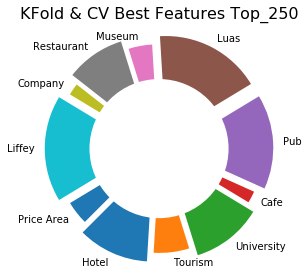

In [658]:
labels = feature_top.keys()
sizes = feature_top.values()
explode = (0.15,0.05,0.15,0.05, 0.15,0.15,0.05,0.15,0.05,0.15,0.05)
plt.pie(sizes, labels=labels,  startangle=225, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('KFold & CV Best Features Top_250', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/KFold_CV_Best_Features_Top_250.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### SVM K-Fold & Cross Validation Score for Top_500 

(following the same methodology that with Top_250)

In [659]:
svm_KF_CV_500 = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures'])

In [661]:
start = time.time()
# limiting the samples scope in order to have y-variance close to unit (defining 1,-1 binomial target) for a balanced model
dff = df.loc[df['Ranking'] <= 1500].copy()
space = '     ' # to print on same line while calculating
# iterated dataframe
svm_combo = pd.DataFrame(columns=['combo', 'KF_acc_mean', 'KF_acc_max', 'KF_acc_min', 'KF_var',
                                  'CV_acc_mean', 'CV_acc_max', 'CV_acc_min', 'CV_var', 'nFeatures'])
i=0
for i in range (0, len(feat_combo)):
    # adding features and target
    X = np.asarray(dff[list(feat_combo[i])])  
    y = np.asarray(dff['Top_500'])
    # setting the classifier
    clf = svm.SVC(kernel = 'rbf', C=5, gamma=(1.15 / (X.shape[1] * X.var())))
    # KFold
    scores = []
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    # cross_val_score
    cv_scores = cross_val_score(clf, X, y, cv=10)
    
    # adding to iterated dataframe
    svm_combo.at[i, 'combo'] = 'fixing bug passing a list into a cell not being an object'
    svm_combo.at[i, 'combo'] = list(feat_combo[i])
    svm_combo.at[i, 'KF_acc_mean'] = np.mean(scores)
    svm_combo.at[i, 'KF_acc_max'] = np.max(scores)
    svm_combo.at[i, 'KF_acc_min'] = np.min(scores)
    svm_combo.at[i, 'KF_var'] = np.var(scores)
    svm_combo.at[i, 'CV_acc_mean'] = cv_scores.mean()
    svm_combo.at[i, 'CV_acc_max'] = cv_scores.max()
    svm_combo.at[i, 'CV_acc_min'] = cv_scores.min()
    svm_combo.at[i, 'CV_var'] = cv_scores.var()
    svm_combo.at[i, 'nFeatures'] = len(list(feat_combo[i]))

    print( '{}{}'.format(svm_combo.at[i, 'combo'], 10*space), end="\r", flush=True) 
# adding each row from the iterated dataframe to the final dataframe
svm_KF_CV_500 = svm_KF_CV_500.append(svm_combo)
print(round(time.time() - start, 3))

534.447', 'Tourism', 'University', 'Cafe', 'Pub', 'Luas', 'Museum', 'Restaurant', 'Company', 'Liffey', 'Price Area']                                                  


In [663]:
#svm_KF_CV_500.to_csv('CSVs/svm_KF_CV_500.csv', index=False)

In [662]:
svm_KF_CV_500.sort_values(by=['KF_acc_max'], ascending=False).head()

,combo,KF_acc_mean,KF_acc_max,KF_acc_min,KF_var,CV_acc_mean,CV_acc_max,CV_acc_min,CV_var,nFeatures
346,"[Hotel, Museum, Liffey, Price Area]",0.464965,0.679012,0.320988,0.0147736,0.593029,0.654321,0.518519,0.00159948,4
103,"[Hotel, Museum, Liffey]",0.460148,0.666667,0.280488,0.0123791,0.581918,0.646341,0.493827,0.00204966,3
342,"[Hotel, Museum, Restaurant, Liffey]",0.457693,0.654321,0.268293,0.0122095,0.586902,0.641975,0.493827,0.00188703,4
1685,"[Hotel, Cafe, Luas, Museum, Company, Liffey, P...",0.471138,0.641975,0.345679,0.00980296,0.595528,0.654321,0.506173,0.00269913,7
1594,"[Hotel, Tourism, Pub, Luas, Museum, Company, P...",0.418127,0.641975,0.283951,0.0143576,0.573351,0.62963,0.506173,0.00184503,7


In [664]:
for column in list(svm_KF_CV_500.columns)[1:]:
    svm_KF_CV_500[column] = svm_KF_CV_500[column].astype('float')

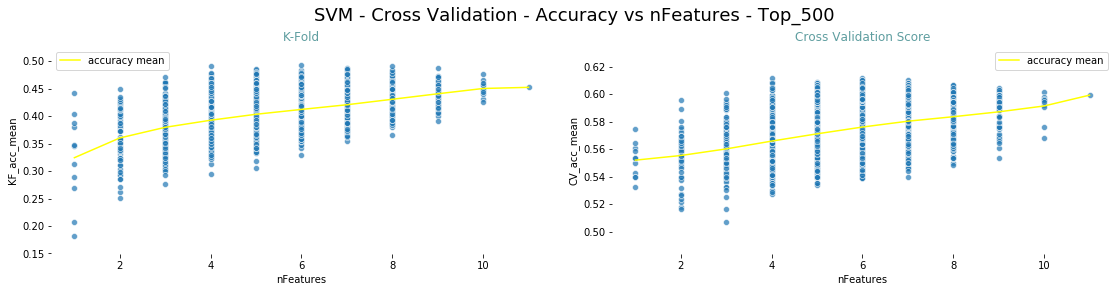

In [665]:
figures = [0, 1]
axis_x = 'nFeatures'
axis_y = ['KF_acc_mean', 'CV_acc_mean']
titles_figs =['K-Fold', 'Cross Validation Score']
data = svm_KF_CV_500
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))
fig.tight_layout(pad=3.0)
fig.suptitle('SVM - Cross Validation - Accuracy vs nFeatures - Top_500', y=1.02, fontsize=18)

for ax_y, titl, figs in zip(axis_y, titles_figs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.7).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_Cross_Val_combo_nfeatures_Top_500.png', bbox_inches='tight', format='png', dpi=500)

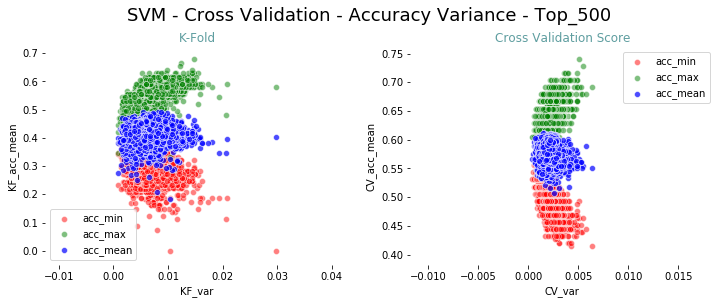

In [667]:
figures = [0, 1]
axis_x = ['KF_var', 'CV_var']
axis_y_min = ['KF_acc_min', 'CV_acc_min']
axis_y_mean = ['KF_acc_mean', 'CV_acc_mean']
axis_y_max = ['KF_acc_max', 'CV_acc_max']
titles_figs =['K-Fold', 'Cross Validation Score']
data = svm_KF_CV_500
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
fig.suptitle('SVM - Cross Validation - Accuracy Variance - Top_500', y=1.02, fontsize=18)
for ax_yi, ax_yea, ax_ya, ax_x, titl, figs in zip(axis_y_min, axis_y_mean, 
                                                  axis_y_max, axis_x, titles_figs, figures):
    sns.scatterplot(x=ax_x, y=ax_yi, data=data, alpha=0.5, 
                    label='acc_min', color='red', ax=axs[figs]).set_title(titl, color='cadetblue')
    sns.scatterplot(x=ax_x, y=ax_ya, data=data, alpha=0.5, 
                    label='acc_max', color='green', ax=axs[figs])
    sns.scatterplot(x=ax_x, y=ax_yea, data=data, alpha=0.7, 
                    label='acc_mean', color='blue', ax=axs[figs])
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_Cross_Val_Accuracy_Variance_Top_500.png', bbox_inches='tight', format='png', dpi=500)

In [670]:
print('KFold: {}'.format(svm_KF_CV_500.loc[(svm_KF_CV_500['KF_var'] < 0.004) 
                        & (svm_KF_CV_500['KF_acc_max'] > 0.5), 'nFeatures'].count()))
print('CV: {}'.format(svm_KF_CV_500.loc[(svm_KF_CV_500['CV_var'] < 0.002) 
                        & (svm_KF_CV_500['CV_acc_max'] > 0.65), 'nFeatures'].count()))

KFold: 197
CV: 227


Let's define some conditions:
* K-Fold < 0.004 variance & > 0.5 accuracy 
* CV < 0.002 variance & > 0.65 accuracy
* combo always above mean() for same nFeature 


In [671]:
KFold_1 = svm_KF_CV_500.loc[(svm_KF_CV_500['KF_var'] < 0.004) 
                            & (svm_KF_CV_500['KF_acc_max'] > 0.5)].copy()
CV_1 = svm_KF_CV_500.loc[(svm_KF_CV_500['CV_var'] < 0.002) 
                            & (svm_KF_CV_500['CV_acc_max'] > 0.65)].copy()
KFold_1.reset_index(drop=True, inplace=True)
CV_1.reset_index(drop=True, inplace=True)

In [672]:
KFold_n_max = svm_KF_CV_500.groupby(by=['nFeatures']).mean()['KF_acc_max'].values
KFold_n_mean = svm_KF_CV_500.groupby(by=['nFeatures']).mean()['KF_acc_mean'].values
KFold_n_min = svm_KF_CV_500.groupby(by=['nFeatures']).mean()['KF_acc_min'].values

CV_n_max = svm_KF_CV_500.groupby(by=['nFeatures']).mean()['CV_acc_max'].values
CV_n_mean = svm_KF_CV_500.groupby(by=['nFeatures']).mean()['CV_acc_mean'].values
CV_n_min = svm_KF_CV_500.groupby(by=['nFeatures']).mean()['CV_acc_min'].values

In [673]:
KFold_2 = pd.DataFrame()
CV_2 = pd.DataFrame()
i=0
for i in range (0, len(KFold_1)):
    if (KFold_1.at[i, 'KF_acc_mean'] > KFold_n_mean[int(KFold_1.at[i, 'nFeatures'])-1]):
        if (KFold_1.at[i, 'KF_acc_min'] > KFold_n_min[int(KFold_1.at[i, 'nFeatures'])-1]):
            if (KFold_1.at[i, 'KF_acc_max'] > KFold_n_max[int(KFold_1.at[i, 'nFeatures'])-1]):
                KFold_2 = KFold_2.append(KFold_1.iloc[i,:])
i=0
for i in range (0, len(CV_1)):
    if (CV_1.at[i, 'CV_acc_mean'] > CV_n_mean[int(CV_1.at[i, 'nFeatures'])-1]):
        if (CV_1.at[i, 'CV_acc_min'] > CV_n_min[int(CV_1.at[i, 'nFeatures'])-1]):
            if (CV_1.at[i, 'CV_acc_max'] > CV_n_max[int(CV_1.at[i, 'nFeatures'])-1]):
                CV_2 = CV_2.append(CV_1.iloc[i,:])

In [674]:
print('KFold group has been reduced from {} to {} samples'.format(KFold_1.shape[0], KFold_2.shape[0]))
print('CV group has been reduced from {} to {} samples'.format(CV_1.shape[0], CV_2.shape[0]))

KFold group has been reduced from 197 to 45 samples
CV group has been reduced from 227 to 199 samples


In [675]:
match_list = []
for KF in KFold_2.combo:
    for CV in CV_2.combo:
        if KF==CV:
            match_list.append(KF)
print('We got {} matches'.format(len(match_list)))

We got 12 matches


In [676]:
KFold_2.reset_index(drop=True, inplace=True)
svm_match500 = pd.DataFrame()
for combo in match_list:
    i=0
    for i in range(0, len(KFold_2)):
        if KFold_2.at[i, 'combo'] == combo:
            svm_match500 = svm_match500.append(KFold_2.iloc[i,:])

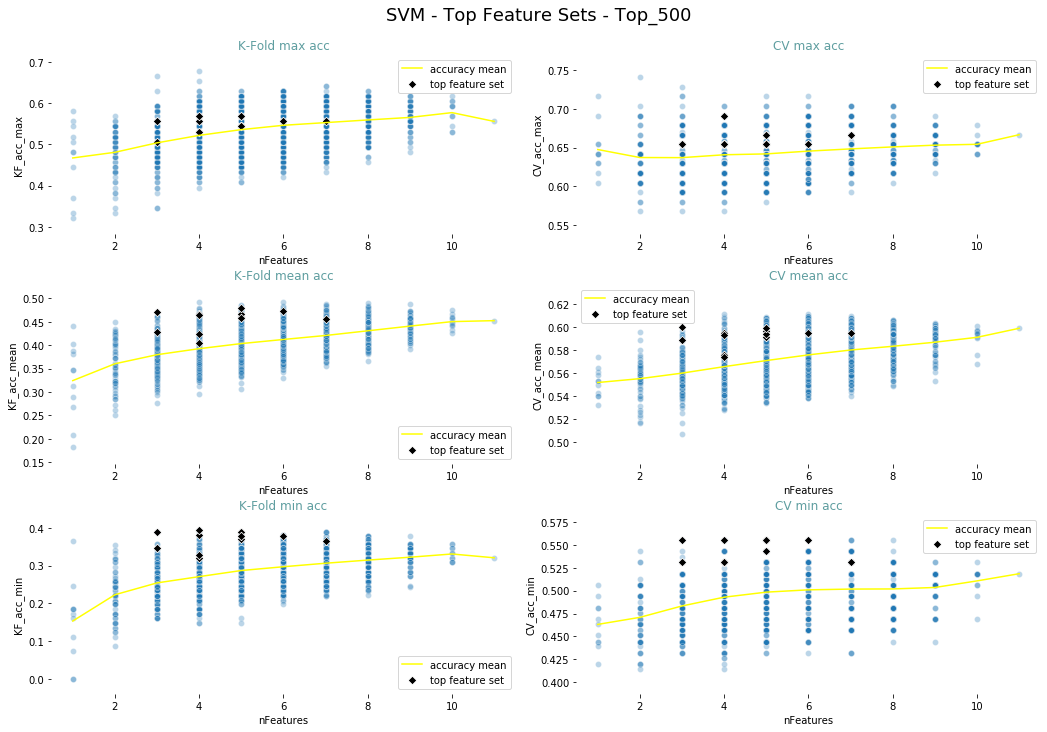

In [677]:
figures = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
axis_x = 'nFeatures'
axis_y = ['KF_acc_max', 'CV_acc_max', 'KF_acc_mean', 'CV_acc_mean', 'KF_acc_min', 'CV_acc_min']
titles_figs =['K-Fold max acc', 'CV max acc', 'K-Fold mean acc', 'CV mean acc', 'K-Fold min acc', 'CV min acc']
data_dfs = [KFold_2, CV_2, KFold_2, CV_2, KFold_2, CV_2]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
fig.tight_layout(pad=3.0)
#fig.suptitle('SVM - Best Feature Sets - Top_250', y=1.02, fontsize=18)
fig.suptitle('SVM - Top Feature Sets - Top_500', y=1.02, fontsize=18)

for ax_y, titl, data_df, figs in zip(axis_y, titles_figs, data_dfs, figures):
    sns.scatterplot(x=axis_x, y=ax_y, data=data, ax=axs[figs], alpha=0.3).set_title(titl, color='cadetblue')
    sns.lineplot(x=data.groupby(by=['nFeatures']).mean()[ax_y].index, 
                 y=data.groupby(by=['nFeatures']).mean()[ax_y].values, 
                 data=data, color='yellow', label='accuracy mean',
                 ax=axs[figs], alpha=1)
    #sns.scatterplot(x=axis_x, y=ax_y, data=data_df, ax=axs[figs], alpha=1, label='potential match', color='red')
    #sns.scatterplot(x=axis_x, y=ax_y, data=svm_match, ax=axs[figs], alpha=1, label='match', color='darkgreen')
    sns.scatterplot(x=axis_x, y=ax_y, data=svm_match500, ax=axs[figs], alpha=1, label='top feature set', color='black', marker='D')
    sns.despine(left=True, top=True, bottom=True, right=True)
fig.savefig('charts/SVM_Top_Feature_Sets_Top_500.png', bbox_inches='tight', format='png', dpi=500)

In [1292]:
print('Top_500 K-Folds accuracy: {} %'.format(round(100*svm_match500.KF_acc_mean.mean(), 2)))
print('Top_500 Cross Validation accuracy: {} %'.format(round(100*svm_match500.CV_acc_mean.mean(), 2)))

Top_500 K-Folds accuracy: 45.45 %
Top_500 Cross Validation accuracy: 59.19 %


For Top_500 the Top feature set are between 3 and 7 features

In [685]:
svm_match500.combo.head(10)

6                   [University, Company, Liffey]
11                  [Restaurant, Company, Liffey]
13         [Tourism, Museum, Restaurant, Company]
14          [University, Pub, Liffey, Price Area]
18            [Cafe, Restaurant, Company, Liffey]
19                 [Pub, Museum, Company, Liffey]
26           [Cafe, Pub, Museum, Company, Liffey]
28       [Cafe, Pub, Restaurant, Company, Liffey]
29    [Cafe, Museum, Restaurant, Company, Liffey]
30     [Pub, Museum, Restaurant, Company, Liffey]
Name: combo, dtype: object

In [680]:
feature_top = {'Hotel':0, 'Tourism':0, 'University':0, 'Cafe':0, 'Pub':0, 
               'Luas':0, 'Museum':0,'Restaurant':0, 'Company':0, 'Liffey':0, 'Price Area':0}
for feat in feature_top.keys():
    for combo in match_list:
        feature_top[feat] += combo.count(feat)
print(feature_top)

{'Hotel': 1, 'Tourism': 1, 'University': 2, 'Cafe': 6, 'Pub': 7, 'Luas': 0, 'Museum': 7, 'Restaurant': 8, 'Company': 11, 'Liffey': 11, 'Price Area': 1}


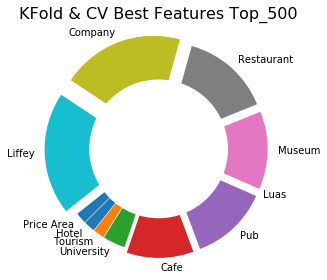

In [683]:
labels = feature_top.keys()
sizes = feature_top.values()
explode = (0.05,0.05,0.05,0.1,0.1, 0.05,0.1,0.1, 0.15,0.15,0.05)
plt.pie(sizes, labels=labels,  startangle=225, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('KFold & CV Best Features Top_500', fontsize=16) 
plt.tight_layout()
plt.savefig('charts/KFold_CV_Best_Features_Top_500.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

In [1287]:
SVM_CV_top_feats_Top_250 = svm_top_feats.copy()
SVM_CV_top_feats_Top_250.to_csv('CSVs/SVM_CV_top_feats_Top_250.csv')

In [1288]:
SVM_CV_top_feats_Top_500 = svm_match500.copy()
SVM_CV_top_feats_Top_500.to_csv('CSVs/SVM_CV_top_feats_Top_500.csv')

### <a id="code2">SVM KFold train set accuracy</a>

(considering best combinations of feature set)

Top_250

In [70]:
SVM_CV_top_feats_Top_250.combo

0                   ['Hotel', 'Pub', 'Luas', 'Liffey']
1    ['Hotel', 'University', 'Luas', 'Restaurant', ...
2    ['Tourism', 'Pub', 'Luas', 'Liffey', 'Price Ar...
3    ['University', 'Pub', 'Luas', 'Restaurant', 'L...
4    ['Hotel', 'University', 'Pub', 'Luas', 'Restau...
5    ['Tourism', 'Pub', 'Luas', 'Restaurant', 'Liff...
6    ['Hotel', 'Tourism', 'University', 'Cafe', 'Pu...
7    ['Hotel', 'University', 'Pub', 'Luas', 'Museum...
8    ['Hotel', 'University', 'Pub', 'Luas', 'Museum...
Name: combo, dtype: object

In [1297]:
dff = df.loc[df['Ranking'] <= 500].copy()                          
svm_train_250 = []
for combo in SVM_CV_top_feats_Top_250.combo:
    X = dff[combo].values 
    y = dff['Top_250'].values
    clf = svm.SVC(kernel = 'rbf', C=5, gamma=(1.15 / (X.shape[1] * X.var())))
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        svm_train_250.append(metrics.accuracy_score(y_train, yhat_train))

print('n Feature set: {}'.format(len(SVM_CV_top_feats_Top_250.combo)))
print('Number of results to calculate the average: {} x 10 Folds = {}'.format(len(SVM_CV_top_feats_Top_250.combo), len(svm_train_250)))
print('SVM K-Fold Train accuracy mean for best feature sets Top_250: {} %'.format(round(100*np.mean(svm_train_250), 2)))

n Feature set: 9
Number of results to calculate the average: 9 x 10 Folds = 90
KNN K-Fold Train accuracy mean for best feature sets Top_250: 63.81 %


Top_500

In [72]:
SVM_CV_top_feats_Top_500.combo

0                   ['University', 'Company', 'Liffey']
1                   ['Restaurant', 'Company', 'Liffey']
2        ['Tourism', 'Museum', 'Restaurant', 'Company']
3         ['University', 'Pub', 'Liffey', 'Price Area']
4           ['Cafe', 'Restaurant', 'Company', 'Liffey']
5                ['Pub', 'Museum', 'Company', 'Liffey']
6        ['Cafe', 'Pub', 'Museum', 'Company', 'Liffey']
7     ['Cafe', 'Pub', 'Restaurant', 'Company', 'Liff...
8     ['Cafe', 'Museum', 'Restaurant', 'Company', 'L...
9     ['Pub', 'Museum', 'Restaurant', 'Company', 'Li...
10    ['Cafe', 'Pub', 'Museum', 'Restaurant', 'Compa...
11    ['Hotel', 'Cafe', 'Pub', 'Museum', 'Restaurant...
Name: combo, dtype: object

In [1296]:
dff = df.loc[df['Ranking'] <= 1500].copy()                          
svm_train_500 = []
for combo in SVM_CV_top_feats_Top_500.combo:
    X = dff[combo].values 
    y = dff['Top_500'].values
    clf = svm.SVC(kernel = 'rbf', C=5, gamma=(1.15 / (X.shape[1] * X.var())))
    cv = KFold(n_splits=10)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        yhat_train = clf.predict(X_train)
        svm_train_500.append(metrics.accuracy_score(y_train, yhat_train))

print('n Feature set: {}'.format(len(SVM_CV_top_feats_Top_500.combo)))
print('Number of results to calculate the average: {} x 10 Folds = {}'.format(len(SVM_CV_top_feats_Top_500.combo), len(svm_train_500)))
print('SVM K-Fold Train accuracy mean for best feature sets Top_500: {} %'.format(round(100*np.mean(svm_train_500), 2)))

n Feature set: 12
Number of results to calculate the average: 12 x 10 Folds = 120
KNN K-Fold Train accuracy mean for best feature sets Top_500: 62.97 %


### <a id="code3">ROC Curve</a>

ROC displays a curve with a point for each of the True Positive Rate and False Positive Rate of the model at distant threshold levels, letting us see the compensation between the FPR and TPR for all threshold levels.

Top_250

In [50]:
svm_total_top_250.sort_values(by=['jaccard_score'], ascending=False).head(2)

,combo,accuracy,accuracy_train,f1_score,jaccard_score,random_state,nFeatures
57759,"['University', 'Cafe', 'Luas', 'Company']",0.734940,0.620061,0.734246,0.580177,84,4
57464,"['University', 'Cafe', 'Luas']",0.710843,0.623100,0.710087,0.550594,84,3


In [63]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit

X = np.asarray(dff[['University', 'Cafe', 'Luas', 'Company']])
y = np.asarray(dff['Top_250']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84, stratify=dff['Top_250']) #Top_250/Top_500
clf = svm.SVC(kernel='rbf', C=5, probability=True, gamma=(1.15 / (X.shape[1] * X.var())))  #probability=True for ROC Curve
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.7349397590361446
f1: 0.7342462874754834
jaccard: 0.5801769168175971


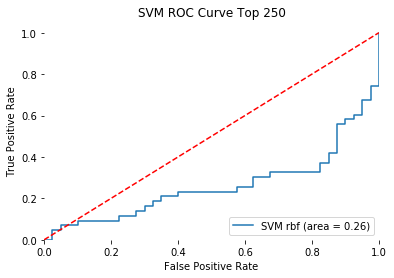

In [64]:
# To get a smooth curve we must to run first svm.SVC with probability parameter True 
svm_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM rbf (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve Top 250')
plt.legend(loc="lower right")
plt.savefig('charts/SVM_ROC_Curve_Top_250_1st.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

In [65]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit

X = np.asarray(dff[['University', 'Cafe', 'Luas']])
y = np.asarray(dff['Top_250']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84, stratify=dff['Top_250']) #Top_250/Top_500
clf = svm.SVC(kernel='rbf', C=5, probability=True, gamma=(1.15 / (X.shape[1] * X.var())))  #probability=True for ROC Curve
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.7108433734939759
f1: 0.7100868590641637
jaccard: 0.550593984328924


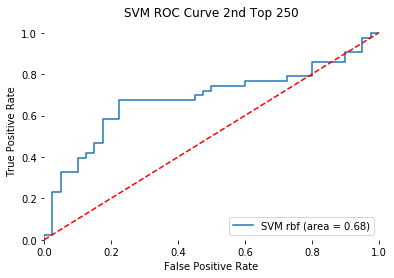

In [66]:
# To get a smooth curve we must to run first svm.SVC with probability parameter True 
svm_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM rbf (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve 2nd Top 250')
plt.legend(loc="lower right")
plt.savefig('charts/SVM_ROC_Curve_Top_250_2nd.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

There is a clear difference in TPR and FPR between the 2 highest accuracies

Top_500

In [54]:
svm_total_top_500.sort_values(by=['accuracy'], ascending=False).head(2)

,combo,accuracy,accuracy_train,f1_score,jaccard_score,random_state,nFeatures
27839,"['Hotel', 'Cafe', 'Pub', 'Luas', 'Liffey', 'Pr...",0.693252,0.628086,0.691741,0.529290,39,6
28265,"['Hotel', 'University', 'Pub', 'Luas', 'Restau...",0.693252,0.634259,0.690474,0.528201,39,7


In [67]:
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500 to keep y.var() close to unit

X = np.asarray(dff[['Hotel', 'Cafe', 'Pub', 'Luas', 'Liffey', 'Price Area']])
y = np.asarray(dff['Top_500']) #Top_250/Top_500
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39, stratify=dff['Top_500']) #Top_250/Top_500
clf = svm.SVC(kernel='rbf', C=5, probability=True, gamma=(1.15 / (X.shape[1] * X.var())))  #probability=True for ROC Curve
clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('acc: {}'.format(metrics.accuracy_score(y_test, yhat)))
print('f1: {}'.format(f1_score(y_test, yhat, average='weighted')))
print('jaccard: {}'.format(jaccard_score(y_test, yhat, average='weighted')))

acc: 0.6932515337423313
f1: 0.691741029931214
jaccard: 0.5292904066453119


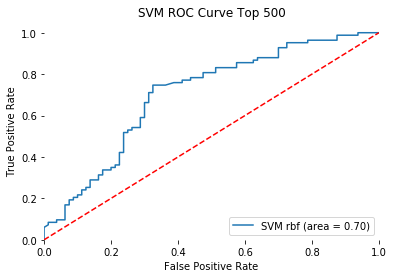

In [68]:
# To get a smooth curve we must to run first svm.SVC with probability parameter True
svm_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM rbf (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve Top 500')
plt.legend(loc="lower right")
plt.savefig('charts/SVM_ROC_Curve_Top_500.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

### <a id="code4">Validation</a>

As we left 40 samples out of the scope to train the classifiers, let's see how they perform.<br>
Notice that all samples are negative, this means that in order to get 100% accuracy the classifier should predict 40 negatives and zero positives.

In [2]:
svm_total_top_250 = pd.read_csv('CSVs/svm_total_top_250.csv')
svm_KF_CV_250 = pd.read_csv('CSVs/svm_KF_CV_250.csv')
svm_total_top_500 = pd.read_csv('CSVs/svm_total_top_500.csv')
svm_KF_CV_500 = pd.read_csv('CSVs/svm_KF_CV_500.csv')

Top_250

In [11]:
dff = df.loc[df['Ranking'] <= 500].copy() # 500/1500 to keep y.var() close to unit
df_val = df.loc[df['Ranking'] > 1500] # 40 samples for validation.
val = pd.DataFrame()
results = [svm_total_top_250, svm_KF_CV_250, svm_KF_CV_250] #Top_250/Top_500
methods = ['random_state', 'KFold', 'cross_val_score']
acc_max = ['accuracy', 'KF_acc_max', 'CV_acc_max' ]

for acc, method, result in zip(acc_max, methods, results):
    feat_set = literal_eval(result.sort_values(by=[acc], ascending=False).head(1)['combo'].values[0])
    X_train = np.asarray(dff[feat_set])
    y_train = np.asarray(dff['Top_250']) #Top_250/Top_500
    X_val = np.asarray(df_val[feat_set])
    y_val = np.asarray(df_val['Top_250']) #Top_250/Top_500

    clf = svm.SVC(kernel='rbf', C=5, gamma=(1.15 / (X_train.shape[1] * X_train.var())))
    clf.fit(X_train, y_train)

    yhat = clf.predict(X_val)
    val_temp = pd.DataFrame([confusion_matrix(y_val, yhat)[0,:]], 
             columns=['Predicted Negative', 'Predicted Positive'], index=[method])
    val = val.append(val_temp)
val.index.name = 'Method' 
val['Accuracy %'] = 100*(val['Predicted Negative']/
                                 (val['Predicted Negative']+val['Predicted Positive']))
svm_val_Top_250 = val.copy()  #Top_250/Top_500
svm_val_Top_250.to_csv('CSVs/SVM_val_Top_250.csv')
svm_val_Top_250

,Predicted Negative,Predicted Positive,Accuracy %
Method,,,
random_state,25,15,62.5
KFold,21,19,52.5
cross_val_score,18,22,45.0


Top_500

In [12]:
dff = df.loc[df['Ranking'] <= 1500].copy() # 500/1500 to keep y.var() close to unit
df_val = df.loc[df['Ranking'] > 1500] # 40 samples for validation.
val = pd.DataFrame()
results = [svm_total_top_500, svm_KF_CV_500, svm_KF_CV_500] #Top_250/Top_500
methods = ['random_state', 'KFold', 'cross_val_score']
acc_max = ['accuracy', 'KF_acc_max', 'CV_acc_max' ]

for acc, method, result in zip(acc_max, methods, results):
    feat_set = literal_eval(result.sort_values(by=[acc], ascending=False).head(1)['combo'].values[0])
    X_train = np.asarray(dff[feat_set])
    y_train = np.asarray(dff['Top_500']) #Top_250/Top_500
    X_val = np.asarray(df_val[feat_set])
    y_val = np.asarray(df_val['Top_500']) #Top_250/Top_500

    clf = svm.SVC(kernel='rbf', C=5, gamma=(1.15 / (X_train.shape[1] * X_train.var())))
    clf.fit(X_train, y_train)

    yhat = clf.predict(X_val)
    val_temp = pd.DataFrame([confusion_matrix(y_val, yhat)[0,:]], 
             columns=['Predicted Negative', 'Predicted Positive'], index=[method])
    val = val.append(val_temp)
val.index.name = 'Method' 
val['Accuracy %'] = 100*(val['Predicted Negative']/
                                 (val['Predicted Negative']+val['Predicted Positive']))
svm_val_Top_500 = val.copy()  #Top_250/Top_500
svm_val_Top_500.to_csv('CSVs/SVM_val_Top_500.csv')
svm_val_Top_500

,Predicted Negative,Predicted Positive,Accuracy %
Method,,,
random_state,23,17,57.5
KFold,20,20,50.0
cross_val_score,26,14,65.0


### Diamond shape of charts versus nFeatures

At higher number of combinations (5 & 6 nFeatures) there is more probability to find extreme max and min (farest from the mean accuracy) running the classifier

Text(0, 0.5, 'combinations')

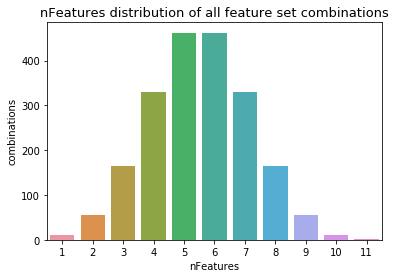

In [14]:
nFeatures_combo = {}
for i in range(1,12):
    nFeatures_combo[i]=0
for combo in feat_combo:
    nFeatures_combo[len(combo)] +=1   
plt.title('nFeatures distribution of all feature set combinations', fontsize=13)
sns.barplot(x=list(nFeatures_combo.keys()), y=list(nFeatures_combo.values()))
plt.xlabel('nFeatures')
plt.ylabel('combinations')
plt.savefig('charts/nFeatures_dist_feat_combo.png', bbox_inches='tight', format='png', dpi=500)

### <center>[NEXT CHAPTER](./D.Prediction_Models_KNN.ipynb#code0)</center>

#### <center> [Table of Contents](./0.Table_of_Contents_Code.ipynb) </center>